In [3]:
import pandas as pd
import os,sys,re,glob
import numpy as np

In [4]:
#df =pd.read_csv("modified_covid19_ts/merged_global2020-06-02.csv")
df = pd.read_csv("modified_covid19_ts/merged_global2020-06-04.csv")
df.head()

,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,NaN,Afghanistan,33.0,65.0,2020-01-22,0,0
1,NaN,Afghanistan,33.0,65.0,2020-01-23,0,0
2,NaN,Afghanistan,33.0,65.0,2020-01-24,0,0
3,NaN,Afghanistan,33.0,65.0,2020-01-25,0,0
4,NaN,Afghanistan,33.0,65.0,2020-01-26,0,0


In [5]:
df["key"] = df.apply(lambda r: str(r["Province/State"]) +"_"+ str(r["Country/Region"]),axis=1)

In [6]:
df.head()

,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,key
0,NaN,Afghanistan,33.0,65.0,2020-01-22,0,0,nan_Afghanistan
1,NaN,Afghanistan,33.0,65.0,2020-01-23,0,0,nan_Afghanistan
2,NaN,Afghanistan,33.0,65.0,2020-01-24,0,0,nan_Afghanistan
3,NaN,Afghanistan,33.0,65.0,2020-01-25,0,0,nan_Afghanistan
4,NaN,Afghanistan,33.0,65.0,2020-01-26,0,0,nan_Afghanistan


In [8]:
gf = {k:v for k,v in df.groupby("key")}
gf ={k.replace("nan_",""):gf[k] for k in gf.keys()}

In [9]:
gff ={k:gf[k] for k in gf.keys() if gf[k].iloc[-1]["Fatalities"] > 100}

In [10]:
len(list(gf.keys())),len(list(gff.keys()))

(266, 73)

In [12]:
for k in gff.keys():
    gff[k]["Daily New Confirmed"] = gff[k]["ConfirmedCases"].diff(1).fillna(0.0)
    gff[k]["7 days New Confirmed"] = gff[k]["ConfirmedCases"].diff(7).fillna(0.0)
    gff[k]["14 days New Confirmed"] = gff[k]["ConfirmedCases"].diff(14).fillna(0.0)
    gff[k]["Total last 14 days ConfirmedCases"] = gff[k]["ConfirmedCases"].rolling(14).sum()

In [13]:
for k in gff.keys():
    gff[k]["Change 14 days"] = (gff[k]["Total last 14 days ConfirmedCases"] - gff[k]["Total last 14 days ConfirmedCases"].shift(14)).fillna(0.0)
    gff[k]["derivative Change 14 days"] = (gff[k]["Change 14 days"]/(1. + gff[k]["Change 14 days"].shift(14)) -1.).round(2)
    gff[k]["derivative2 Change 14 days"] = (gff[k]["14 days New Confirmed"]/(1. + gff[k]["14 days New Confirmed"].shift(14)) -1.).round(2)

In [14]:
import random
LL = list(gff.keys())
Lr = random.sample(LL,10)
count=0
AA=[]
BB=[]
for x in LL:
    d1 = gff[x].copy().fillna(0.0)
    d1 = d1[d1["Date"]>"2020-05-01"]
    d1 = d1.sort_values(by ="derivative Change 14 days")[["Date","key","Change 14 days","derivative Change 14 days","derivative2 Change 14 days"]]
    dN = d1.sort_values(by ="derivative2 Change 14 days")[["Date","key","Change 14 days","derivative Change 14 days","derivative2 Change 14 days"]]

    tail_d = list(d1.tail()["Date"])
    
    if not "2020-05-02" in tail_d and d1.iloc[-1]["derivative Change 14 days"]>0.5:
        count+=1
        print(d1.tail())
        AA.append(d1.iloc[-1]["key"].replace("nan_",""))
    
    tail_N = list(dN.tail()["Date"])
    if not "2020-05-02" in tail_d and d1.iloc[-1]["derivative2 Change 14 days"]>1.:
        #count+=1
        #print(d1.tail())
        BB.append(d1.iloc[-1]["key"].replace("nan_",""))
    
        

print(count)
print(AA)
print(BB)

           Date              key  Change 14 days  derivative Change 14 days  \
111  2020-05-12  nan_Afghanistan         29646.0                       1.77   
115  2020-05-16  nan_Afghanistan         38601.0                       1.80   
114  2020-05-15  nan_Afghanistan         36204.0                       1.81   
113  2020-05-14  nan_Afghanistan         33915.0                       1.81   
112  2020-05-13  nan_Afghanistan         31778.0                       1.81   

     derivative2 Change 14 days  
111                        1.81  
115                        1.56  
114                        1.60  
113                        1.60  
112                        1.84  
           Date          key  Change 14 days  derivative Change 14 days  \
379  2020-05-12  nan_Algeria         28664.0                       0.50   
383  2020-05-16  nan_Algeria         31583.0                       0.51   
382  2020-05-15  nan_Algeria         30818.0                       0.51   
381  2020-05-14  nan_

             Date       key  Change 14 days  derivative Change 14 days  \
17948  2020-05-27  nan_Iran        353991.0                       0.53   
17952  2020-05-31  nan_Iran        389566.0                       0.54   
17949  2020-05-28  nan_Iran        363414.0                       0.55   
17951  2020-05-30  nan_Iran        381072.0                       0.55   
17950  2020-05-29  nan_Iran        372458.0                       0.56   

       derivative2 Change 14 days  
17948                        0.51  
17952                        0.37  
17949                        0.47  
17951                        0.39  
17950                        0.43  
             Date       key  Change 14 days  derivative Change 14 days  \
18085  2020-05-30  nan_Iraq         24495.0                       0.89   
18086  2020-05-31  nan_Iraq         26422.0                       0.99   
18087  2020-06-01  nan_Iraq         28528.0                       1.08   
18088  2020-06-02  nan_Iraq         31124.0

In [17]:
for k in AA:
    print(k,gf[k].iloc[-30]["Fatalities"],gf[k].iloc[-1]["Fatalities"])
print("="*40)
for k in BB:
    print(k,gf[k].iloc[-30]["Fatalities"],gf[k].iloc[-1]["Fatalities"])
print("^"*40)
df_changes = pd.DataFrame(columns=["Country","Total Deats Month ago","Total Deaths Today"])
count =0
for k in BB:
    if  gf[k].iloc[-30]["Fatalities"] > 200:
        print(k,gf[k].iloc[-30]["Fatalities"],gf[k].iloc[-1]["Fatalities"])
        df_changes.loc[count] = [k,gf[k].iloc[-30]["Fatalities"],gf[k].iloc[-1]["Fatalities"]]
        count+=1
df_changes.to_csv("NewWave.csv")

        
        


Afghanistan 95 294
Algeria 470 673
Argentina 264 583
Armenia 40 170
Bolivia 86 400
Brazil 7938 32548
Bulgaria 80 146
Cameroon 64 200
Chile 275 1275
Colombia 378 1057
Ecuador 1569 3486
Egypt 452 1088
Guatemala 19 143
Honduras 93 234
Iran 6340 8012
Iraq 102 256
Korea, South 255 273
Kuwait 40 230
Nigeria 98 315
Pakistan 514 1688
South Africa 148 792
Afghanistan 95 294
Argentina 264 583
Armenia 40 170
Bolivia 86 400
Brazil 7938 32548
Chile 275 1275
Colombia 378 1057
Ecuador 1569 3486
Egypt 452 1088
Guatemala 19 143
Honduras 93 234
Iraq 102 256
Kuwait 40 230
Nigeria 98 315
Pakistan 514 1688
Philippines 637 974
South Africa 148 792
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Argentina 264 583
Brazil 7938 32548
Chile 275 1275
Colombia 378 1057
Ecuador 1569 3486
Egypt 452 1088
Pakistan 514 1688
Philippines 637 974


In [18]:
owid =  pd.read_csv("/Users/itaybd/Documents/owid-covid-data.csv")

In [64]:
owid["deaths/cases"] =100.*( owid["total_deaths"]/owid["total_cases"])
owid.columns

Index(['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k',
       'deaths/cases'],
      dtype='object')

In [65]:
gfo = {k:v for k,v in owid.groupby("location")}
gfok ={k:gfo[k] for k in gfo.keys() if gfo[k].iloc[-1]['total_deaths']>200}

In [66]:
list(gfok.keys())

['Afghanistan',
 'Algeria',
 'Argentina',
 'Austria',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Bolivia',
 'Brazil',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Czech Republic',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'Finland',
 'France',
 'Germany',
 'Honduras',
 'Hungary',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kuwait',
 'Mexico',
 'Moldova',
 'Morocco',
 'Netherlands',
 'Nigeria',
 'Norway',
 'Pakistan',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Serbia',
 'South Africa',
 'South Korea',
 'Spain',
 'Sudan',
 'Sweden',
 'Switzerland',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 'World']

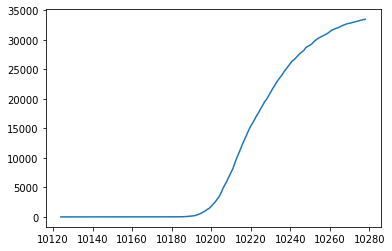

In [67]:
from matplotlib import pyplot as plt
#plt.plot(gfok['World']['total_deaths'])
#plt.plot(gfok['Israel']['total_deaths'])
plt.plot(gfok['Italy']['total_deaths'])
plt.show()


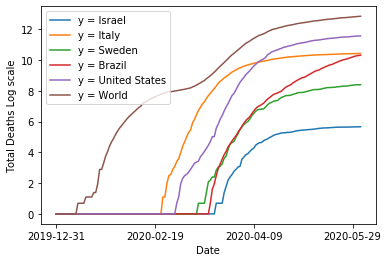

In [68]:
from matplotlib import pyplot as plt
import math
#plt.plot(gfok['World']['total_deaths'])
#plt.plot(gfok['Israel']['total_deaths'])
gfok["Israel"]#gfok["World"]#gfok['Italy']
L_c = ["Israel","Italy","Sweden","Brazil",'United States',"World"]

spacing =20
dfL = [gfok[c].set_index('date') for c in L_c]
for df1 in dfL:
    plt.plot(df1.apply(lambda r: math.log(1.+r['total_deaths']),axis=1))

#plt.gcf().autofmt_xdate()
short_dates = [d for d in dfL[0].index.values][::10]
"""

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xticks(np.arange(len(short_dates)))
plt.xticks(rotation=30)

for label in ax.xaxis.get_ticklabels()[::spacing]:
    label.set_visible(False)
"""
plt.xticks(short_dates[::5])

#ax.legend(loc=4, fontsize=10)
plt.xlabel("Date")
plt.ylabel("Total Deaths Log scale")
plt.legend(['y = %s'%cc for cc in L_c], loc='upper left')


plt.show()


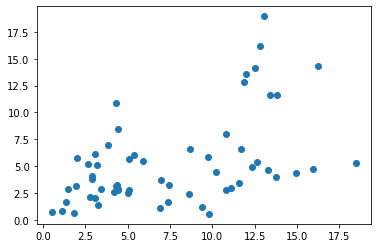

In [69]:
X=[]
Y=[]
for k in gfok.keys():
    #print(k)
    #print(gfok[k].iloc[-1][["aged_70_older",'deaths/cases']])
    X.append(gfok[k].iloc[-1]["aged_70_older"])
    Y.append(gfok[k].iloc[-1]["deaths/cases"])
    #Y.append(gfok[k].iloc[-1]["gdp_per_capita"])
plt.scatter(X,Y)
plt.show()
    
    

OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Austria 13.748 45436.685999999994 4.008881954029887 668
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Czech Republic 11.58 32605.906000000003 3.4508707804773167 321
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Denmark 12.325 46682.515 4.923497734849133 576
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Finland 13.264000000000001 40585.721 4.647785039941903 320
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Ireland 8.677999999999999 67335.293 6.583672492219296 1650
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Israel 7.359 33132.32 1.6667634589697427 287
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Japan 18.493 39002.223 5.280567040756055 894
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Norway 10.812999999999999 64800.057 2.8058494828201166 236
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
South Korea 8.622 35938.373999999996 2.356814834069838 272
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Sweden 13.433 46949.282999999996 11.643835616438356 4403
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO


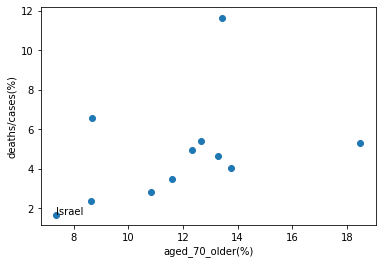

In [71]:
gfokw = {k:gfok[k] for k in gfok.keys() if gfok[k].iloc[-1]["gdp_per_capita"]>30000}
X=[]
Y=[]
Exclude =["United Arab Emirates","Kuwait","Saudi Arabia"]
A1=[]
B1 = []
for k in gfokw.keys():
    if not k in Exclude:
        #print(k)
        #print(gfok[k].iloc[-1][["aged_70_older",'deaths/cases']])
        #X.append(gfokw[k].iloc[-1]["aged_70_older"])
        #Y.append(gfokw[k].iloc[-1]["deaths/cases"])
        #Y.append(gfok[k].iloc[-1]["gdp_per_capita"])
        if(gfokw[k].iloc[-1]["aged_70_older"]<3.):
            print(k,gfokw[k].iloc[-1]["aged_70_older"],gfok[k].iloc[-1]["gdp_per_capita"],gfokw[k].iloc[-1]["deaths/cases"])
        if(gfokw[k].iloc[-1]["total_deaths"]< 5000 ):
            print("O"*40)
            X.append(gfokw[k].iloc[-1]["aged_70_older"])
            Y.append(gfokw[k].iloc[-1]["deaths/cases"])
            
            A1.append(gfokw[k].iloc[-1]["aged_70_older"])
            B1.append(gfokw[k].iloc[-1]["deaths/cases"])
            print(k,gfokw[k].iloc[-1]["aged_70_older"],gfok[k].iloc[-1]["gdp_per_capita"],gfokw[k].iloc[-1]["deaths/cases"],gfokw[k].iloc[-1]["total_deaths"])
#plt.scatter(X,Y)
fig, ax = plt.subplots()
ax.scatter(X, Y)

#for i, txt in enumerate(n):
k = "Israel"
ax.annotate(k, (gfokw[k].iloc[-1]["aged_70_older"], gfokw[k].iloc[-1]["deaths/cases"]))
plt.xlabel("aged_70_older(%)")
plt.ylabel("deaths/cases(%)")
plt.show()

In [53]:
import numpy as np
np.corrcoef(A1,B1)[0,1]

0.8156724157620294

OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Austria 106.749 74.169 4.008881954029887 668
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Belarus 46.858000000000004 25.399 0.5529571688592954 240
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Denmark 136.52 99.444 4.923497734849133 576
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Finland 18.136 57.754 4.647785039941903 320
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Honduras 82.805 21.909000000000002 4.046997389033943 217
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Hungary 108.04299999999999 55.07 13.567967355266514 532
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Ireland 69.874 334.157 6.583672492219296 1650
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Israel 402.606 33.158 1.6667634589697427 287
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Moldova 123.655 76.104 3.672248803827751 307
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Norway 14.462 43.532 2.8058494828201166 236
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Panama 55.133 79.726 2.48608802486088 344
OOOOOOOOOOOOOOOOOOOOOOOO

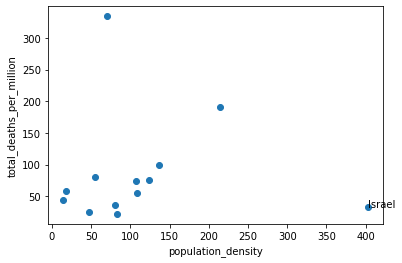

In [81]:
#gfokw = {k:gfok[k] for k in gfok.keys() if gfok[k].iloc[-1]["gdp_per_capita"]>30000}
X=[]
Y=[]
Exclude =["United Arab Emirates","Kuwait","Saudi Arabia"]
A1=[]
B1 = []
for k in gfok.keys():
    if not k in Exclude:
        #print(k)
        #print(gfok[k].iloc[-1][["aged_70_older",'deaths/cases']])
        #X.append(gfokw[k].iloc[-1]["aged_70_older"])
        #Y.append(gfokw[k].iloc[-1]["deaths/cases"])
        #Y.append(gfok[k].iloc[-1]["gdp_per_capita"])
        if(gfok[k].iloc[-1]["population"]< 10000000 ):
            print("O"*40)
            X.append(gfok[k].iloc[-1]["population_density"])
            Y.append(gfok[k].iloc[-1]["total_deaths_per_million"])
            
            #A1.append(gfokw[k].iloc[-1]["aged_70_older"])
            #B1.append(gfokw[k].iloc[-1]["deaths/cases"])
            print(k,gfok[k].iloc[-1]["population_density"],gfok[k].iloc[-1]["total_deaths_per_million"],gfok[k].iloc[-1]["deaths/cases"],gfok[k].iloc[-1]["total_deaths"])
#plt.scatter(X,Y)
fig, ax = plt.subplots()
ax.scatter(X, Y)

#for i, txt in enumerate(n):
k = "Israel"
ax.annotate(k, (gfokw[k].iloc[-1]["population_density"], gfokw[k].iloc[-1]["total_deaths_per_million"]))
plt.xlabel("population_density")
plt.ylabel("total_deaths_per_million")
plt.show()